In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import pickle
import plotly.graph_objects as go

from utils.util import read_yaml
from box import Box

import optuna
from sklearn.metrics import mean_squared_error
from math import sqrt

from utils.eda_tools import select_good_period, single_column_vis
import warnings
warnings.filterwarnings('ignore')

## V3: Add time lag feature vs Not add, on LNG data

### Load Data

In [2]:
cfg = Box(read_yaml('../src/conf/config.yaml'))
Config = Box(read_yaml('../src/conf/baseline.yaml'))

In [5]:
df_path = '../data/lng_data_before_model.csv'
df = pd.read_csv(df_path, parse_dates=True, index_col=0)

In [6]:
df.shape

(22816, 585)

In [7]:
df.head()

,314PDC037.MEAS,314FC019.MEAS,312TC016.MEAS,315TC032.MEAS,344TC018.MEAS,315PC005.MEAS,312LC013.MEAS,315FC004.MEAS,314FC012.MEAS,314LC004.MEAS,...,314TZ130.PNT,314TZ131.PNT,314U852.PNT,313PD001.PNT,313PD002.PNT,362PZ033.PNT,62T611.PNT,PK1211A_3.PNT,PK1181A_3.PNT,314FT010.PNT
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,32.404493,1.895956,143.736979,29.737596,29.104980,3.542643,17.648540,0.235888,0.025301,61.579427,...,1.540138,1.448554,3.30484,0.536413,-0.002637,0.018355,29.838867,1.726875,5.066797,9872.846517
2020-01-01 01:00:00,32.491994,7.100584,123.322917,29.616227,28.727539,3.525716,14.499538,0.228320,0.020929,61.496419,...,1.532720,1.411494,3.34147,0.537354,-0.002637,0.018355,29.838867,1.726875,5.066797,9888.568034
2020-01-01 02:00:00,32.456642,7.296492,123.212240,29.475968,28.360840,3.520833,11.717770,0.227886,0.017645,61.358073,...,1.485584,1.465100,3.70370,0.535478,-0.002637,0.018355,29.161784,1.726875,5.066797,9899.958171
2020-01-01 03:00:00,32.359572,3.071405,215.477865,29.352701,28.124023,3.513835,20.699776,0.226183,0.015626,61.455404,...,1.520795,1.520258,3.35368,0.535104,-0.002637,0.018355,29.026367,1.726875,5.066797,9883.221354
2020-01-01 04:00:00,32.377931,11.610827,319.933594,29.232630,27.868164,3.504639,20.414889,0.219501,0.018392,61.518555,...,1.544646,1.429978,3.30077,0.530957,-0.002637,0.018355,29.026367,1.726875,5.066797,9892.548665


### Split Live Data

In [8]:
df.shape

(22816, 585)

In [9]:
# split and the keep the last 10% as live data
df, live_df = train_test_split(df, test_size=0.1, shuffle=False)
df.shape, live_df.shape

((20534, 585), (2282, 585))

### Not Adding Time Lag Feature

In [23]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)
# split the data into train, validation and test set by 8:1:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False, random_state=42)

In [24]:
X_train.shape, X_test.shape, X_val.shape

((16427, 584), (2054, 584), (2053, 584))

In [25]:
best_model_on_shuffled = XGBRegressor(**Config.xgboost_regressor_config.model_config)
# best_model_on_shuffled = XGBRegressor(**{'n_estimators': 4000, 'max_depth': 10, 'learning_rate': 0.007561363159167393, 'subsample': 0.8131065794452833, 'colsample_bytree': 0.5664053001442664, 'min_child_weight': 9, 'reg_alpha': 0.08703941325890176, 'reg_lambda': 0.2848960362084546, 'early_stopping_rounds': 37})

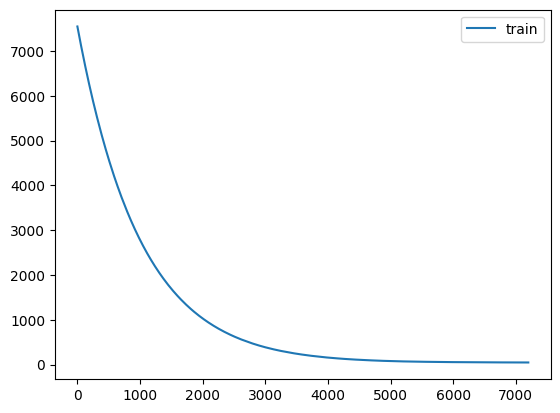

In [26]:
best_model_on_shuffled.fit(X_train, y_train, 
             eval_set=[(X_val, y_val)], verbose=False)

results = best_model_on_shuffled.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
# plt.plot(results['validation_1']['rmse'], label='validation')
# show the legend
plt.legend()
# show the plot
plt.show()

In [27]:
# calculate the rmse on train and test set
from sklearn.metrics import mean_squared_error
from math import sqrt

y_train_pred = best_model_on_shuffled.predict(X_train)
y_val_pred = best_model_on_shuffled.predict(X_val)
y_test_pred = best_model_on_shuffled.predict(X_test)

rmse_train_shuffled = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val_shuffled = sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test_shuffled = sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE on train set:", rmse_train_shuffled)
print("RMSE on validation set:", rmse_val_shuffled)
print("RMSE on test set:", rmse_test_shuffled)

RMSE on train set: 27.0597041930846
RMSE on validation set: 47.078143703686266
RMSE on test set: 62.21619293914881


In [28]:
# calculate the rmse on live set
live_X = live_df.iloc[:, :-1]
live_y = live_df.iloc[:, -1]

live_y_pred = best_model_on_shuffled.predict(live_X)
rmse_live_shuffled = sqrt(mean_squared_error(live_y, live_y_pred))
print("RMSE on live set:", rmse_live_shuffled)

RMSE on live set: 61.03087783944493


#### Visualization

In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=live_X.index, y=live_y, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=live_X.index, y=live_y_pred, mode='lines', name='prediction'))
fig.update_layout(title='Prediction on Live Set for Best Model Trained on Shuffled Data Adding Lagged Feature Y',
                xaxis_title='Date',
                yaxis_title='Y Value',
                width=1200,
                height=600)
# fig.write_html(cfg.shuffle_or_not.v2.shuffle.live_plot)
fig.show()

### Adding Time Lag Feature

In [10]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# add a time lag column of y to X
X['y_lag'] = y.shift(1)
# X['y_lag2'] = y.shift(2)
# X['y_lag3'] = y.shift(3)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False, random_state=42)

In [13]:
best_model_on_unshuffled = XGBRegressor(**Config.xgboost_regressor_config.model_config)
# best_model_on_unshuffled = XGBRegressor(**{'n_estimators': 9000, 'max_depth': 2, 'learning_rate': 0.05974183269036751, 'subsample': 0.4678621497249791, 'colsample_bytree': 0.878451077257514, 'min_child_weight': 3, 'reg_alpha': 0.7586221690145304, 'reg_lambda': 0.5213509710908082, 'early_stopping_rounds': 42})

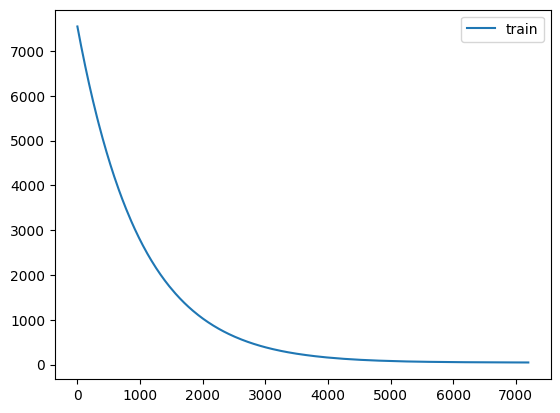

In [14]:
best_model_on_unshuffled.fit(X_train, y_train, 
             eval_set=[(X_val, y_val)], verbose=False)

results = best_model_on_unshuffled.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
# plt.plot(results['validation_1']['rmse'], label='validation')
# show the legend
plt.legend()
# show the plot
plt.show()

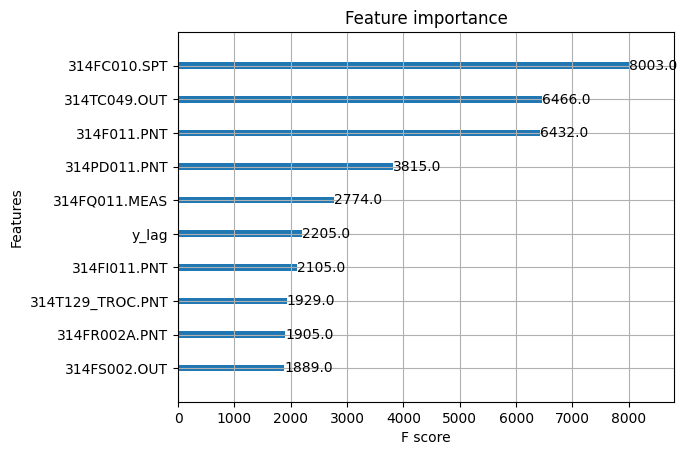

In [15]:
# feature importance
from xgboost import plot_importance
plot_importance(best_model_on_unshuffled, max_num_features=10)
plt.show()

In [16]:
y_train_pred = best_model_on_unshuffled.predict(X_train)
y_val_pred = best_model_on_unshuffled.predict(X_val)
y_test_pred = best_model_on_unshuffled.predict(X_test)

rmse_train_unshuffled = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val_unshuffled = sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test_unshuffled = sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE on train set:", rmse_train_unshuffled)
print("RMSE on validation set:", rmse_val_unshuffled)
print("RMSE on test set:", rmse_test_unshuffled)

RMSE on train set: 27.414283683298667
RMSE on validation set: 48.34765403489032
RMSE on test set: 59.653298494188256


In [17]:
# calculate the rmse on live set
live_X = live_df.iloc[:, :-1]
live_y = live_df.iloc[:, -1]
live_X['y_lag'] = live_y.shift(1)
# live_X['y_lag2'] = live_y.shift(2)
# live_X['y_lag3'] = live_y.shift(3)


live_y_pred = best_model_on_unshuffled.predict(live_X)
rmse_live_unshuffled = sqrt(mean_squared_error(live_y, live_y_pred))
print("RMSE on live set:", rmse_live_unshuffled)

RMSE on live set: 61.2640940535451


#### Visualization

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_train.index, y=y_train, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=X_train.index, y=y_train_pred, mode='lines', name='prediction'))
fig.update_layout(title='Prediction on Train Set for Best Model Trained on Unshuffled Data Adding Lagged Feature Y',
                xaxis_title='Date',
                yaxis_title='Y Value',
                width=1200,
                height=600)
# fig.write_html(cfg.shuffle_or_not.v2.unshuffle.train_plot)
fig.show()

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_val.index, y=y_val, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=X_val.index, y=y_val_pred, mode='lines', name='prediction'))
fig.update_layout(title='Prediction on Validation Set for Best Model Trained on Unshuffled Data Adding Lagged Feature Y',
                xaxis_title='Date',
                yaxis_title='Y Value',
                width=1200,
                height=600)
# fig.write_html(cfg.shuffle_or_not.v2.unshuffle.val_plot)
fig.show()

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_test_pred, mode='lines', name='prediction'))
fig.update_layout(title='Prediction on Test Set for Best Model Trained on Unshuffled Data Adding Lagged Feature Y',
                xaxis_title='Date',
                yaxis_title='Y Value',
                width=1200,
                height=600)
# fig.write_html(cfg.shuffle_or_not.v2.unshuffle.test_plot)
fig.show()

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=live_X.index, y=live_y, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=live_X.index, y=live_y_pred, mode='lines', name='prediction'))
fig.update_layout(title='Prediction on Live Set for Best Model Trained on Unshuffled Data Adding Lagged Feature Y',
                xaxis_title='Date',
                yaxis_title='Y Value',
                width=1200,
                height=600)
# fig.write_html(cfg.shuffle_or_not.v2.unshuffle.live_plot)
fig.show()

In [22]:
# truncate the live set from Jan 28 to Feb 3
live_X_sample = live_X.loc['2023-01-28':'2023-02-03']
live_y_sample = live_y.loc['2023-01-28':'2023-02-03']
# get the prediction on the live set from Jan 28 to Feb 3
live_y_pred_sample = best_model_on_unshuffled.predict(live_X_sample)

fig = go.Figure()
fig.add_trace(go.Scatter(x=live_X_sample.index, y=live_y_sample, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=live_X_sample.index, y=live_y_pred_sample, mode='lines', name='prediction'))
fig.update_layout(title='Prediction on Live Set for Best Model Trained on Unshuffled Data Adding Lagged Feature Y',
                xaxis_title='Date',
                yaxis_title='Y Value',
                width=1200,
                height=600)
fig.show()

### Summary

In [30]:
# make a table to compare the results

# create a dataframe to store the results
results_df = pd.DataFrame(columns=['RMSE on Train Set', 'RMSE on Validation Set', 'RMSE on Test Set', 'RMSE on Live Set'], index=['Shuffled Data', 'Unshuffled Data'])
results_df.loc['Shuffled Data', 'RMSE on Train Set'] = rmse_train_shuffled
results_df.loc['Shuffled Data', 'RMSE on Validation Set'] = rmse_val_shuffled
results_df.loc['Shuffled Data', 'RMSE on Test Set'] = rmse_test_shuffled
results_df.loc['Shuffled Data', 'RMSE on Live Set'] = rmse_live_shuffled

results_df.loc['Unshuffled Data', 'RMSE on Train Set'] = rmse_train_unshuffled
results_df.loc['Unshuffled Data', 'RMSE on Validation Set'] = rmse_val_unshuffled
results_df.loc['Unshuffled Data', 'RMSE on Test Set'] = rmse_test_unshuffled
results_df.loc['Unshuffled Data', 'RMSE on Live Set'] = rmse_live_unshuffled

results_df

,RMSE on Train Set,RMSE on Validation Set,RMSE on Test Set,RMSE on Live Set
Shuffled Data,27.059704,47.078144,62.216193,61.030878
Unshuffled Data,27.414284,48.347654,59.653298,61.264094


In [31]:
# using plotly to visualize the table
fig = go.Figure(data=[go.Table(
    header=dict(values=list(results_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[results_df['RMSE on Train Set'], results_df['RMSE on Validation Set'], results_df['RMSE on Test Set'], results_df['RMSE on Live Set']],
                fill_color='lavender',
                align='left'))
])

fig.update_layout(title='Comparison of RMSE on Different Datasets for Best Model Trained on Shuffled and Unshuffled Data Adding Lagged Feature Y',
                width=1200,
                height=600)
# save fig as html
# fig.write_html(cfg.shuffle_or_not.v2.table)
fig.show()